In [1]:
import tensorflow as tf #importowanie wymaganych bibliotek
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [3]:
# wczytanie modelu z poprzednich zajec
json_file = open('./testowanie/model.json', 'r')
loaded_model_json = json_file.read()


In [4]:
# json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./testowanie/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [5]:
#przygotowanie nowych danych /content/chfpln_d.csv

In [36]:
data = pd.read_csv('./dane/chfpln_d.csv')#wczytanie pliku

In [37]:
zmienna_przewidywana = "Zamkniecie"


def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych
  dataset = scaler.fit_transform(dataset)
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler

In [38]:
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, data, ratio=0.5)


def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [39]:
#ewaluacja modelu
def evaluation_model(model,X_train, X_test, Y_train):
  dataset = data[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  # invert predictions
  
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])

  print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
  print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))

  return Y_train, train_predict

In [40]:
#spradzamy jak model dziala na nowych danych, rowniez porownujemy sobie z wielkoscia batchu

In [41]:
# wielkosc batchu [10, 20, 50]

for batch in [10, 20, 50]:
  
  evaluation_model(loaded_model,X_train, X_test, Y_train)
  print(evaluation_model)


Train Mean Absolute Error: 0.16545565856291294
Train Root Mean Squared Error: 0.17541909401805436
<function evaluation_model at 0x0000020CF8365280>
Train Mean Absolute Error: 0.16545565856291294
Train Root Mean Squared Error: 0.17541909401805436
<function evaluation_model at 0x0000020CF8365280>
Train Mean Absolute Error: 0.16545565856291294
Train Root Mean Squared Error: 0.17541909401805436
<function evaluation_model at 0x0000020CF8365280>


In [42]:
#wizualizacja wynikow

In [43]:
Y_train, train_predict = evaluation_model(loaded_model,X_train, X_test, Y_train)

Train Mean Absolute Error: 0.16545565856291294
Train Root Mean Squared Error: 0.17541909401805436


In [44]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0])
  aa=[x for x in range(N)]
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual")
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show();


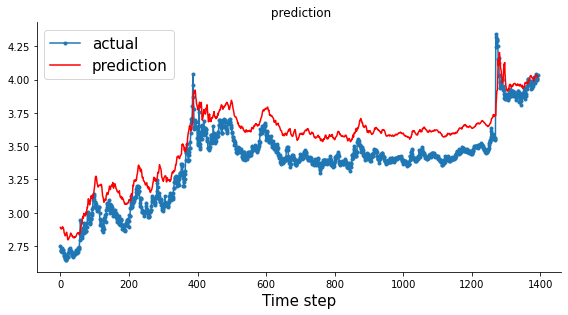

In [45]:
visualization(Y_train, train_predict)

In [46]:
#jak widac, model ma dobra zdolnosc do generalizacji na nowcyh danych - na wczesniejszych danych byla para usd pln, teraz ch usd